## ANN
- 입력 / 은닉 / 출력 레이어
- **Activation function** (뉴런 동작 흉내, 비선형성 보상)
- 분류 문제의 출력용 activation function ; **Softmax** (출력 노드 결과 확률값으로 바꿈 -> cross entropy 적용 가능)
- **Back Propagation**, **Gradient Descent**(가중치에 대한 loss function 미분값 활용)
- **Loss Function**
    - 분류 문제에선 **Cross Entropy**
    - 회귀 문제에선 **Mean Squared Error** 
- 최적화 방법 
    - SGD
    - RMSprop
    - Adam(경사의 분산과 평균으로 부터 파라미터 업데이트)
    - Adagrad(밀집되지 않은 데이터에 적합하도록 경사 제곱을 통해 시간에 따라 학습률 조정)
    

## 구현 모양새
- **layers** ; 각 계층을 만드는 모듈
- **models** ; 각 layer를 연결하여 뉴럴넷을 만들고, compile, fit, evaluation하는 역할
- 케라스는 **연쇄 / 분산** 방식으로 모델을 구현할 수 있음
    - 연쇄 방식은 간단하지만 복잡한 모델 구현 힘듬
- 또 각각, **함수형 / 객체지향형** 방식으로 구현 가능

In [1]:
from keras import layers, models

Using TensorFlow backend.


#### 분산 방식 모델링을 포함하는 함수형 구현

In [15]:
def ANN_models_func(Nin, Nh, Nout):
    x = layers.Input(shape=(Nin,)) # 입력 계층 별도 지정
    h = layers.Activation('relu')(layers.Dense(Nh)(x)) # 객체를 함수처럼 쓸 수 있는 파이썬, __call__(self, x)
    y = layers.Activation('softmax')(layers.Dense(Nout)(h))
    model = models.Model(x, y)
    # 컴파일 ; 타겟 플랫폼에 맞게 딥러닝 코드 구성(수행속도 최적화 및 초기화 작업)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#### 연쇄 방식의 모델링을 포함하는 함수형 구현

In [14]:
def ANN_seq_func(Nin, Nh, Nout):
    model = models.Sequential()
    model.add(layers.Dense(Nh, activation='relu', input_shape=(Nin,)))
    model.add(layers.Dense(Nout, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#### 분산 방식 모델링을 포함하는 객체지향형 구현
- 모델의 재사용성 높이기 위한 객체지향 방식
- 클래스를 만들고 models.Model 상속(학습, 예측, 평가 함수 제공)

In [17]:
class ANN_models_class(models.Model):
    """
        hidden layer가 여러개라면 루프 써서 정의 가능
        
        Nh_l = [5, 10, 5]
        hidden_l = [layers.Dense(n) for n in Nh_l]
        output = layers.Dense(Nout)
        
        가져다 쓸 땐 model = ANN_models_class(Nin, Nh, Nout)
        가져다 쓰기 쉬운 구조
    """
    def __init__(self, Nin, Nh, Nout):
        hidden = layers.Dense(Wh)
        output = layers.Dense(Nout)
        relu = layers.Activation('relu')
        softmax = layers.Activation('softmax')
        
        x = layers.Input(shape=(Nin,))
        h = relu(hidden(x))
        y = softmax(output(h))
        
        super().__init__(x, y)
        self.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        

#### 연쇄 방식 모델링을 포함하는 객체지향형 구현
- 분산 방식에선 각 레이어를 별도로 직접 정의..
    - 컴파일 직전에 부모 초기화
- 연쇄 방식은 뉴럴넷이 연속적인 하나의 고리로 연결되어 있다고 가정
    - 자신의 초기화 가장 앞단에서 부모 초기화

In [19]:
class ANN_seq_class(models.Sequential):
    def __init__(self, Nin, Nh, Nout):
        super().__init__()
        self.add(layers.Dense(Nh, activation='relu', input_shape=(Nin,)))
        self.add(layers.Dense(Nout, activation='softmax'))
        self.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 데이터 가져오기
- **training, validation, test data**
- validation data ; 학습이 진행되는 동안 성능 검증
- test data ; 학습 끝낸 이후에 모델 성능 최종 평가

In [21]:
import numpy as np
from keras import datasets
from keras.utils import np_utils

def Data_func():
    (X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
    # one-hot vector
    Y_train = np_utils.to_categorical(y_train)
    Y_test = np_utils.to_categorical(y_test)
    
    L, W, H = X_train.shape
    print (L, W, H)
    X_train = X_train.reshape(-1, W * H)
    X_test = X_test.reshape(-1, W * H)
    
    # 정규화
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    return (X_train, Y_train), (X_test, Y_test)

## 학습 결과
- fit() 함수의 결과인 history 변수에 학습 과정의 데이터가 들어있음
- epoch는 반복 학습 횟수, batch_size는 한번에 학습하는 양

In [12]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss']) # 선그리기
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0) # 각 라인의 표식 표시

def plot_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

In [24]:
def main():
    Nin = 784
    Nh = 100
    number_of_class = 10
    Nout = number_of_class
    
    model = ANN_seq_class(Nin, Nh, Nout)
    (X_train, Y_train), (X_test, Y_test) = Data_func()
    
    ############
    # train 
    ############
    history = model.fit(X_train, Y_train, epochs=15, batch_size=100, validation_split=0.2)
    performance_test = model.evaluate(X_test, Y_test, batch_size=100) # eval할 때도 batch를 지정함
    
    print('Test Loss and Accuracy -> {:.2f}, {:.2f}'.format(*performance_test))
    
    plot_loss(history)
    plt.show()
    
    plot_acc(history)
    plt.show()    

60000 28 28
Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 2s 49us/step - loss: 0.3953 - acc: 0.8917 - val_loss: 0.2214 - val_acc: 0.9391
Epoch 2/15
48000/48000 [==============================] - 2s 47us/step - loss: 0.1934 - acc: 0.9446 - val_loss: 0.1701 - val_acc: 0.9518
Epoch 3/15
48000/48000 [==============================] - 2s 42us/step - loss: 0.1434 - acc: 0.9579 - val_loss: 0.1373 - val_acc: 0.9597
Epoch 4/15
48000/48000 [==============================] - 2s 42us/step - loss: 0.1118 - acc: 0.9671 - val_loss: 0.1226 - val_acc: 0.9633
Epoch 5/15
48000/48000 [==============================] - 2s 36us/step - loss: 0.0912 - acc: 0.9739 - val_loss: 0.1150 - val_acc: 0.9647
Epoch 6/15
48000/48000 [==============================] - 3s 52us/step - loss: 0.0766 - acc: 0.9777 - val_loss: 0.1067 - val_acc: 0.9674
Epoch 7/15
48000/48000 [==============================] - 1s 31us/step - loss: 0.0643 - acc: 0.9814 - val_loss: 0.10

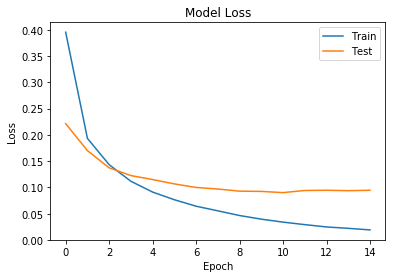

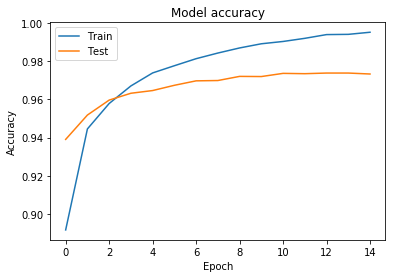

In [25]:
main()

#### 결과
- validation set에 대한 손실 및 정확도는 training set에 대한 것 보다 점점 나빠짐
- 해당 모델이 가지는 자유도에 비해 학습 데이터 수가 적거나, 학습 방법에 한계가 있어 오는 **'overfitting'**
- overfitting 방지법
    - early stopping
    - 모델의 params 수 줄이기